회귀 실습
===
자전거 대여 수요 예측
---
### 1. 전처리

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv("./csv_data/train_bike.csv")

print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()  #null없음 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# 문자열을 datetime 타입으로 변경
bike_df["datetime"] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df["year"] = bike_df.datetime.apply(lambda x : x.year)
bike_df["month"] = bike_df.datetime.apply(lambda x : x.month)
bike_df["day"] = bike_df.datetime.apply(lambda x : x.day)
bike_df["hour"] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [4]:
bike_df.info()  # Data type 확인 후 불필요한 목록 삭제

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

In [5]:
drop_columns = ["datetime", "casual", "registered"]
# casual, regi : 사전에 등록되었는지 여부에 따른 대여 횟수
bike_df.drop(drop_columns, axis=1, inplace=True)

### 2. 에러 함수들 정의 후 선형회귀 학습/예측

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSE 계싼
def rmsle(y, pred) :
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error() 를 이용하여 RMSE로 계산
def rmse(y, pred) :
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y, pred) : 
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y, pred)
    print(f"RMSLE : {rmsle_val:.3f}, RMSE : {rmse_val:.3f}, MAE : {mae_val:.3f}")

In [7]:
# 학습 데이터, 테스트 데이터 분리
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df["count"]
X_features = bike_df.drop(["count"], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                        test_size=0.3, random_state=0)

# 선형회귀 적용 후 학습/예측/평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)
# RMSLE에 비해 RMSE값이 매우 크게 나왔음.
# 예측 에러가 매우 큰 값들이 섞여있기 때문.

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


### 3. 예측값과 실제값 오차 확인

In [8]:
def get_top_error_data(y_test, pred, n_tops = 5) :
    # DataFrame의 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=["real_count"])
    result_df["predicted_count"] = np.round(pred)
    result_df["diff"] = np.abs(result_df["real_count"] - result_df["predicted_count"])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values("diff", ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


### 4. 타겟값에 로그를 취해서 정규화

In [9]:
# 타겟 컬럼인 count 값을 log1p 로 Log 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log 를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log,
                                    test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1을 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmp1으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)
# 아직도 RMSLE에 비해 RMSE값이 매우 크게 나옴

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


### 5. 피처 별 회귀 계수 확인

<AxesSubplot:>

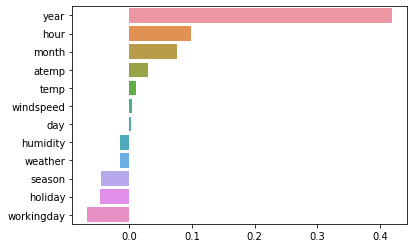

In [10]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

# year(2011, 2012)가 영향력이 큰 것을 볼 수 있음
# → 해당 데이터는 2011년에 창업한 스타트업으로
# 2012년부터 더 성장해 대여 수요량이 늘어난 것.

### 6. 원-핫 인코딩 후 다시 학습/예측

In [11]:
# "year", "month", "hour", "season", "weather" feature들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=["year", "month", "hour", "holiday",
                                            "workingday", "season", "weather"])

In [12]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                        test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
# 기본 선형회귀와 릿지, 라쏘 모델에 대해 성능 평가를 해주는 함수
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False) :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print("###", model.__class__.__name__, "###")
    evaluate_regr(y_test, pred)
# end of function get_model_predict

In [13]:
# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

# 이전보다 RMSE가 많이 줄은 것을 볼 수 있음

### LinearRegression ###
RMSLE : 0.589, RMSE : 97.484, MAE : 63.106
### Ridge ###
RMSLE : 0.589, RMSE : 98.407, MAE : 63.648
### Lasso ###
RMSLE : 0.634, RMSE : 113.031, MAE : 72.658


### 7. 원-핫 인코딩 후 회귀 계수 확인

<AxesSubplot:>

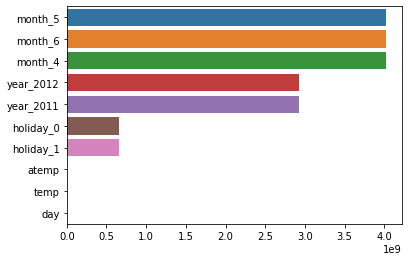

In [14]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 8. 회귀 트리 사용

In [16]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# # 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
# rf_reg = RandomForestRegressor(n_estimators=500)
# gbm_reg = GradientBoostingRegressor(n_estimators=500)

# for model in [rf_reg, gbm_reg] :
#     # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능, ndarray로 변환.
#     get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)